# How to solve a linear system using VQLS

This how-to guide explain how to sovle a linear systems of equations using VQLS

## Step 1: Create your linear system

A linear system of equation is defined by a matrix $A$ and a vector $b$ that together define the linear system $A\times x = b$. The goal is of course to determine the value of the vector $x$. VQLS only works for symmetric matrices, i.e. $A^\dagger = A$. Let's first generate a random matrix $A$ and a random vector $b$.

In [1]:
import numpy as np

# size of the system
size = 4

# matrix of the linear system
A = np.random.rand(size,size)
A = A + A.T

# right hand side of the linear system
b = np.random.rand(size)

## Step 2 : Define the variational ansatz

As all variational algorithms, VQLS uses a variational circuits called an ansatz and usually denoted $V(\theta)$ to solve the problem at hand. During the optimization, the parameters of the ansatz ($\theta$) are gradually modified to minimze a cost function. In VQLS the ansatz creates a proposed solution vector $|x\rangle$ from the $|0\rangle$ state: 

$$|x\rangle = V(\theta)|0\rangle$$

The choice of the ansatz is therefore important as the true solution vector must be within reach for a give values of the parameters. In this tutorial we will use one of the predefined variational circuits contained in qiskit, the `RealAmplitude` circuit.

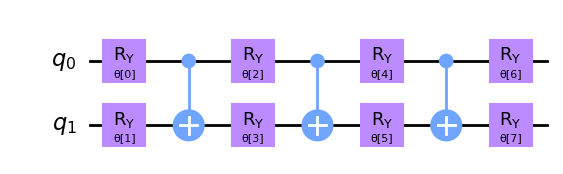

In [2]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
nqbit = int(np.log2(size))
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3, insert_barriers=False)
ansatz.decompose().draw('mpl')

## Step 3 : Instantiate the VQLS solver

We can now use the VQLS solver to obtain a solution of the linear system $A\times x = b$. 

In [3]:
from qalcore.qiskit.vqls.vqls import VQLS, VQLSLog
from qiskit.primitives import Estimator 
from qiskit.algorithms import optimizers as opt

# instantiate an estimator primitive
estimator = Estimator()

# create a logger 
log = VQLSLog([],[])

# create the vqls solver
vqls = VQLS(
    estimator,
    ansatz,
    opt.CG(maxiter=200),
    callback=log.update 
)

## Step 4 : Solve the system of equations

The solver can easily be used to obtain a solution

In [4]:
res = vqls.solve(A, b)

/home/nico/miniconda3/envs/hera_cal/lib/python3.8/site-packages/qiskit/quantum_info/operators/symplectic/sparse_pauli_op.py:131: ComplexWarning: Casting complex values to real discards the imaginary part
  self._coeffs = np.asarray((-1j) ** (phase - count_y) * coeffs, dtype=coeffs.dtype)


## Step 5 : Visualize the evolution of the loss function

We can use the values logged in our dedicated logger to visualize how the value of the cost function evolves during the optimization process.  

Text(0.5, 0, 'Iterations')

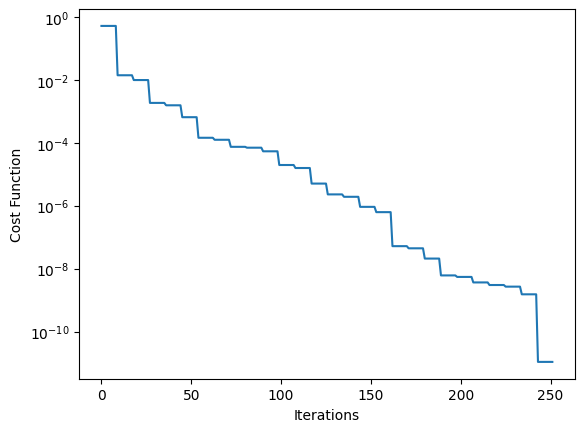

In [7]:
import matplotlib.pyplot as plt
plt.semilogy(log.values)
plt.ylabel('Cost Function')
plt.xlabel('Iterations')

## Step 6 : validate the solution vector

The solution vector is now encoded in the state created by the variational circuit. We can access this vector and verify that the solution vector solves the linear system 

In [11]:
from qiskit.quantum_info import Statevector
vqls_solution = np.real(Statevector(res.state).data)

False

We can now compute the solution using `numpy.linalg.solve` and compare the solutions given by the two methods

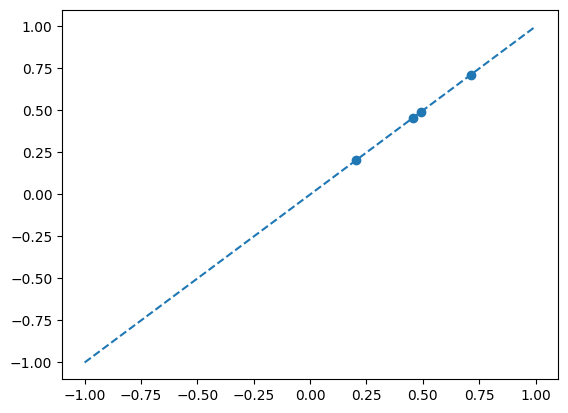

In [14]:
ref_solution = np.linalg.solve(A, b/np.linalg.norm(b))
ref_solution = ref_solution / np.linalg.norm(ref_solution)

plt.scatter(ref_solution, -vqls_solution)
plt.plot([-1, 1], [-1, 1], "--")